In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

## Training data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [132]:
test_no_bg = process_data.remove_background(scan_100206_long, mask_100206_long)

In [133]:
test_begin_0 = np.where(test_no_bg[:, 0] == 0)[0]

In [136]:
test_begin_0

array([ 46080,  52289,  58710,  61649,  65169,  75865,  77984,  82681,
        88184,  96165,  96248,  98616, 104386, 104471, 105834, 106935,
       112589, 112845, 112930, 115186, 115316, 121280, 121706, 124612,
       127409, 130165, 130591, 132693, 133084, 133597, 137541, 139400,
       139753, 141694, 141918, 142846, 148444, 148806, 149505, 149838,
       151134, 151227, 151272, 152002, 152206, 152349, 152407, 154601,
       156409, 158104, 158288, 158471, 159177, 159511, 160888, 160932,
       161452, 161721, 161983, 161984, 162113, 162132, 162210, 167928,
       168205, 168297, 169004, 169341, 171395, 171798, 171931, 171948,
       172006, 172027, 172164, 172422, 172512, 172608, 172704, 178028,
       178213, 179261, 181980, 182142, 182491, 182588, 182685, 188111,
       188564, 189253, 189586, 191392, 191682, 192585, 192681, 192778,
       198338, 199046, 199391, 199725, 201834, 202277, 202792, 205301,
       208912, 209605, 209942, 211902, 211903, 211904, 212326, 212401,
      

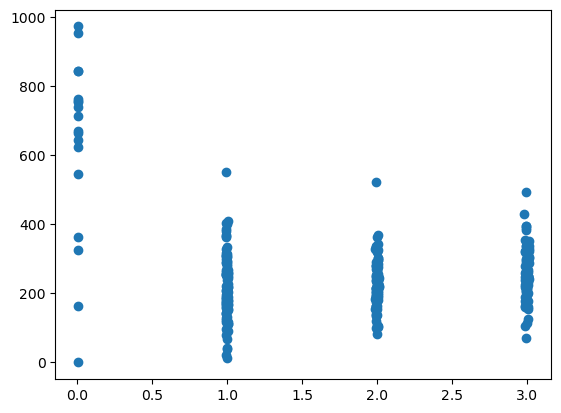

In [143]:
plt.plot(bvals_all, test_no_bg[930422,:], "o")

In [139]:
scan_100206_long[845451,:]

array([6704.40283203,  630.99127197,  211.24629211,  318.82394409,
        504.55914307,  386.30993652,  155.88322449,  526.62475586,
        516.15020752,  194.31488037,  611.7791748 ,  190.4210968 ,
        295.01586914,  593.07910156,  203.78581238,  384.11517334,
       6972.23583984,  425.44396973,  228.13539124,  277.37646484,
        345.67700195,  351.22134399,  300.18267822,  445.92837524,
        269.26135254,  308.71716309,  732.16296387,  377.91653442,
        229.0055542 ,  528.04382324,  261.96670532,  253.05070496,
       6568.37011719,  202.08164978,  553.2454834 ,  218.13262939,
        555.94897461,  278.75131226,  355.13546753,  266.76965332,
        206.87550354,  261.34887695,  244.15737915,  660.43737793,
        194.80184937,  469.1257019 ,  258.69174194,  293.92440796,
       7040.28076172,  547.21337891,  353.21115112,  339.99447632,
        260.35806274,  280.42892456,  289.72915649,  671.47375488,
        261.31918335,  388.38677979,  676.94488525,  295.99072

In [5]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indices_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [13]:
bvals_all = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [14]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all)

In [15]:
normalized_scan_100206 = scan_100206_long_no_background / S0_100206

In [16]:
len(np.where(S0_100206 < 100)[0])

609

In [17]:
big_b_indices = np.where(bvals_all != 0.005)[0]

In [18]:
bvals = bvals_all[big_b_indices]

In [19]:
normalized_scan_100206_no_b5 = normalized_scan_100206[:, big_b_indices]

In [20]:
normalized_scan_100206_no_b5.shape

(935442, 270)

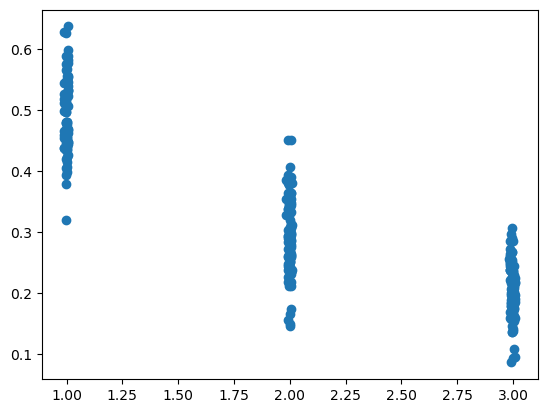

In [21]:
plt.plot(bvals, normalized_scan_100206_no_b5[1565,:], "o")

In [46]:
np.save("normalized_scan_100206_no_b5.npy",normalized_scan_100206_no_b5)

In [4]:
normalized_scan_100206_no_b5 = np.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/normalised_data/normalized_scan_100206_no_b5.npy")

## Neural Network

In [22]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [23]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [24]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [25]:
n_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n = n_all[:,big_b_indices].T
print(n.shape)

b_values = torch.FloatTensor(bvals)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

(270, 3)


In [26]:
batch_size = 128
num_batches = len(normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [27]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 50

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.91it/s]


Loss: 1419.8857786655426
Average Loss: 0.1942919784709281
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.98it/s]


Loss: 554.9689288991503
Average Loss: 0.07593991911592096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.29it/s]


Loss: 430.094368558377
Average Loss: 0.058852540853636705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.54it/s]


Loss: 429.9818527651951
Average Loss: 0.05883714460388548
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.31it/s]


Loss: 434.1288801834453
Average Loss: 0.05940460867315891
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.58it/s]


Loss: 444.6091322200373
Average Loss: 0.06083868804324539
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.41it/s]


Loss: 438.3083509292919
Average Loss: 0.059976512168759155
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.23it/s]


Loss: 428.2842303402722
Average Loss: 0.058604848158220056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.21it/s]


Loss: 422.8946396042593
Average Loss: 0.05786735626768737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 158.90it/s]


Loss: 424.0153364120051
Average Loss: 0.058020708321292434
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  2%|█                                                         | 126/7308 [00:03<00:54, 131.40it/s]

X_batch: 
torch.Size([128, 270])
tensor([[0.2665, 0.1237, 0.1383,  ..., 0.2473, 0.1544, 0.0752],
        [0.5114, 0.2537, 0.1421,  ..., 0.4717, 0.2329, 0.0787],
        [0.4234, 0.2984, 0.2241,  ..., 0.5849, 0.2427, 0.1498],
        ...,
        [0.5473, 0.2527, 0.0990,  ..., 0.5036, 0.2424, 0.1879],
        [0.7680, 0.3057, 0.2319,  ..., 0.7978, 0.3959, 0.1823],
        [0.3349, 0.1124, 0.1296,  ..., 0.2961, 0.2456, 0.1292]])
X_pred: 
torch.Size([128, 270])
tensor([[0.2869, 0.1476, 0.0973,  ..., 0.2803, 0.1505, 0.1239],
        [0.4496, 0.2196, 0.1334,  ..., 0.4455, 0.2425, 0.1485],
        [0.5114, 0.2796, 0.1687,  ..., 0.5130, 0.2738, 0.1683],
        ...,
        [0.4679, 0.2461, 0.1386,  ..., 0.4603, 0.2607, 0.1726],
        [0.6846, 0.4703, 0.3227,  ..., 0.6837, 0.4698, 0.3230],
        [0.3035, 0.1837, 0.1311,  ..., 0.2985, 0.1836, 0.1676]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.85it/s]


Loss: 428.46233697468415
Average Loss: 0.058629219618867565
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.31it/s]


Loss: 430.69304538704455
Average Loss: 0.05893446160194917
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.66it/s]


Loss: 445.3245311703067
Average Loss: 0.060936580619910606
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.27it/s]


Loss: 479.3677036180161
Average Loss: 0.06559492386672361
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.44it/s]


Loss: 474.21692586224526
Average Loss: 0.0648901102712432
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.81it/s]


Loss: 559.2828076840378
Average Loss: 0.07653021451615187
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.54it/s]


Loss: 496.2144817006774
Average Loss: 0.06790017538323447
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.15it/s]


Loss: 496.9802421457134
Average Loss: 0.06800495924270845
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.68it/s]


Loss: 486.29051574878395
Average Loss: 0.06654221616704761
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 10


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.40it/s]


Loss: 447.0148981376551
Average Loss: 0.06116788425528943
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 11


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.68it/s]


Loss: 441.3051953946706
Average Loss: 0.060386589408137736
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 12


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.20it/s]


Loss: 461.8606717302464
Average Loss: 0.06319932563358599
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 13


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.92it/s]


Loss: 478.8948052600026
Average Loss: 0.06553021418445575
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 14


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.80it/s]


Loss: 459.3173432741314
Average Loss: 0.06285130586673938
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 15


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.59it/s]


Loss: 447.4347477769479
Average Loss: 0.061225334944847824
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 16


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.31it/s]


Loss: 439.49327449896373
Average Loss: 0.06013865277763598
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 17


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.54it/s]


Loss: 438.6036387733184
Average Loss: 0.06001691827768451
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 18


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.97it/s]


Loss: 434.05146299209446
Average Loss: 0.05939401518775239
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 19


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.63it/s]


Loss: 435.10299649462104
Average Loss: 0.05953790318755077
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 20


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.24it/s]


Loss: 438.81753568700515
Average Loss: 0.06004618714928916
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 21


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 158.97it/s]


Loss: 448.4519839505665
Average Loss: 0.06136452982355863
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 22


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.41it/s]


Loss: 439.1286256292369
Average Loss: 0.06008875555955623
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 23


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.66it/s]


Loss: 443.4470255514607
Average Loss: 0.06067966961568975
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 24


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.21it/s]


Loss: 443.4747952858452
Average Loss: 0.06068346952460935
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 25


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.13it/s]


Loss: 445.45300014829263
Average Loss: 0.0609541598451413
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 26


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.40it/s]


Loss: 439.58602798264474
Average Loss: 0.060151344825211374
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 27


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.82it/s]


Loss: 455.6013500376139
Average Loss: 0.06234282293891816
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 28


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.35it/s]


Loss: 448.3847044601571
Average Loss: 0.061355323544082796
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 29


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.47it/s]


Loss: 450.95708580571227
Average Loss: 0.061707318802095276
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 30


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.32it/s]


Loss: 443.31406687153503
Average Loss: 0.060661476036061174
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 31


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.88it/s]


Loss: 460.9017083584331
Average Loss: 0.06306810459201329
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 32


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.52it/s]


Loss: 488.43356405803934
Average Loss: 0.06683546306212908
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 33


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.87it/s]


Loss: 548.7848577061668
Average Loss: 0.07509371342448916
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 34


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.29it/s]


Loss: 505.1899708751589
Average Loss: 0.06912834850508469
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 35


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.09it/s]


Loss: 520.0831074700691
Average Loss: 0.07116627086344678
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 36


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.98it/s]


Loss: 515.9588682577014
Average Loss: 0.07060192504894655
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 37


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.94it/s]


Loss: 483.1169567722827
Average Loss: 0.06610795796008248
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 38


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 140.74it/s]


Loss: 486.8019169885665
Average Loss: 0.06661219444287993
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 39


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.37it/s]


Loss: 497.4806994460523
Average Loss: 0.06807343998988127
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 40


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.38it/s]


Loss: 471.7778055067174
Average Loss: 0.06455634995986828
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 41


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.06it/s]


Loss: 466.1350302444771
Average Loss: 0.06378421322447689
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 42


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.53it/s]


Loss: 460.838957764674
Average Loss: 0.06305951803019622
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 43


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.64it/s]


Loss: 456.290145246312
Average Loss: 0.06243707515685715
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 44


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.22it/s]


Loss: 453.39444289542735
Average Loss: 0.06204083783462334
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 45


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.76it/s]


Loss: 455.53626632411033
Average Loss: 0.06233391712152577
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 46


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.60it/s]


Loss: 453.25635218666866
Average Loss: 0.06202194200693331
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 47


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.32it/s]


Loss: 450.3193195569329
Average Loss: 0.061620049200456065
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 48


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.71it/s]


Loss: 449.79799250047654
Average Loss: 0.061548712712161543
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 49


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.99it/s]

Loss: 449.40485144453123
Average Loss: 0.06149491672749469
Done, best loss: 422.8946396042593
Done


<All keys matched successfully>

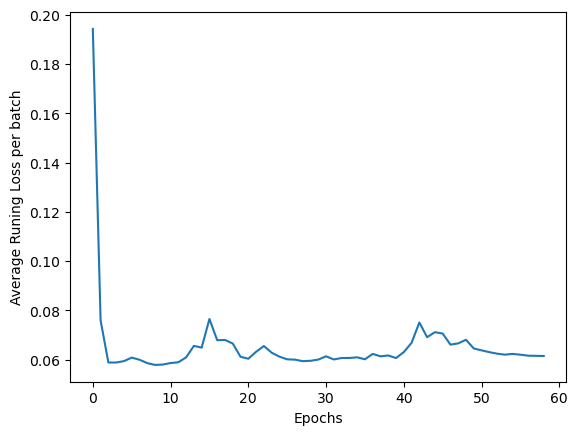

In [28]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [38]:
torch.save(final_model, 'model_100206_norm_01_Feb_58e_better_range.pt')

In [29]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [30]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train = net(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)))

In [31]:
lambda_iso_pred_train.shape

torch.Size([935442, 1])

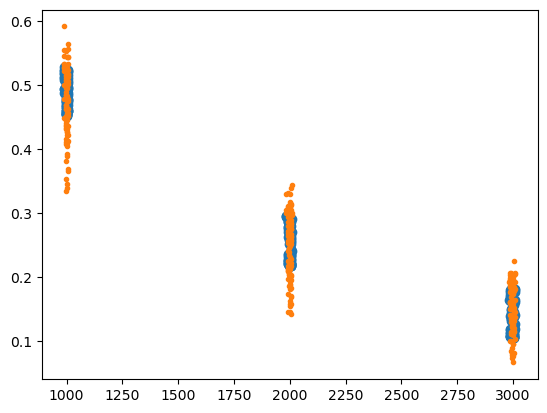

In [37]:
plt.plot(bvals*1e03, X_pred_train[12309,:].detach().numpy(),  "o")
plt.plot(bvals*1e03,normalized_scan_100206_no_b5[12309,:], ".")

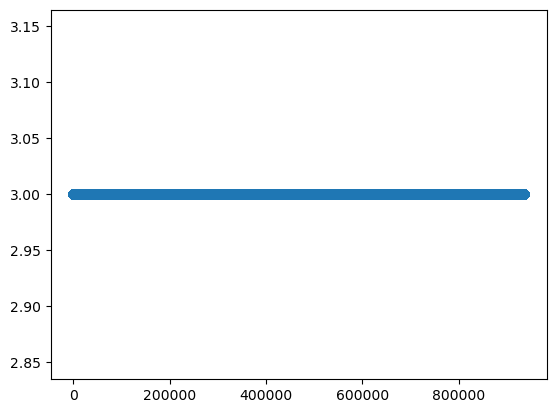

In [35]:
plt.plot(lambda_par_pred_train.detach().numpy(), 'o')

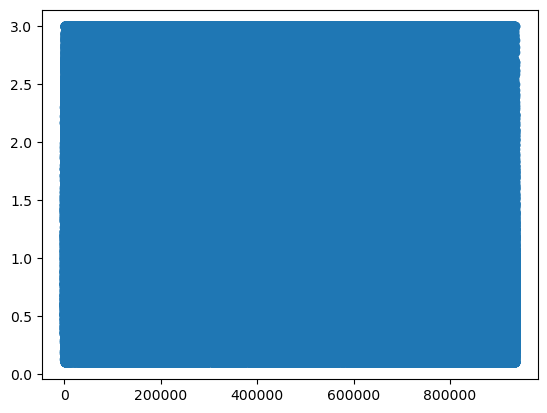

In [34]:
plt.plot(lambda_iso_pred_train.detach().numpy(), 'o')

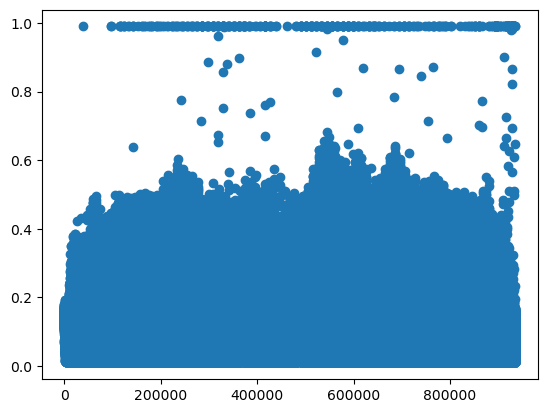

In [36]:
plt.plot(volume_0_pred_train.detach().numpy(), 'o')

In [39]:
def add_bg(mask_long, params):
    resume_params = np.copy(mask_long)
    no_bg_indices = np.where(mask_long == 1)[0]
    for i, index in enumerate(no_bg_indices):
        resume_params[index] = params[i]
    return resume_params

def back_to_3D(mask_long, parames_1d, shape):
    params_with_bg = add_bg(mask_long, parames_1d.detach().numpy())
    params_3d = np.reshape(params_with_bg, shape)
    return params_3d

In [40]:
lambda_par_pred_train_3d = back_to_3D(mask_100206_long_pro, lambda_par_pred_train, (145, 174, 145))

In [41]:
lambda_iso_pred_train_3d = back_to_3D(mask_100206_long_pro, lambda_iso_pred_train, (145, 174, 145))

In [42]:
volume_0_pred_train_3d = back_to_3D(mask_100206_long_pro, volume_0_pred_train, (145, 174, 145))

In [43]:
volume_1_pred_train_3d = back_to_3D(mask_100206_long_pro, volume_1_pred_train, (145, 174, 145))

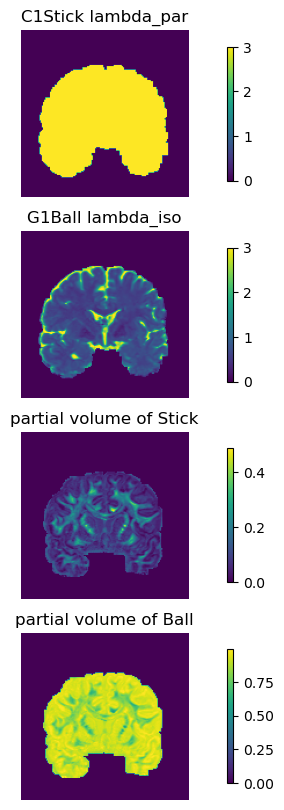

In [44]:
fig, axs = plt.subplots(4, 1, figsize=[10, 10])
axs = axs.ravel()

cf = axs[0].imshow(lambda_par_pred_train_3d[:,100,:].squeeze().T, origin='lower')
axs[0].set_title("C1Stick lambda_par")
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.8)

cf = axs[1].imshow(lambda_iso_pred_train_3d[:,100,:].squeeze().T, origin='lower')
axs[1].set_title("G1Ball lambda_iso")
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.8)

cf = axs[2].imshow(volume_0_pred_train_3d[:,110,:].squeeze().T, origin='lower')
axs[2].set_title("partial volume of Stick")
axs[2].set_axis_off()
fig.colorbar(cf, ax=axs[2], shrink=0.8)

cf = axs[3].imshow(volume_1_pred_train_3d[:,110,:].squeeze().T, origin='lower')
axs[3].set_title("partial volume of Ball")
axs[3].set_axis_off()
fig.colorbar(cf, ax=axs[3], shrink=0.8)

NameError: name 'fitted_parameters' is not defined

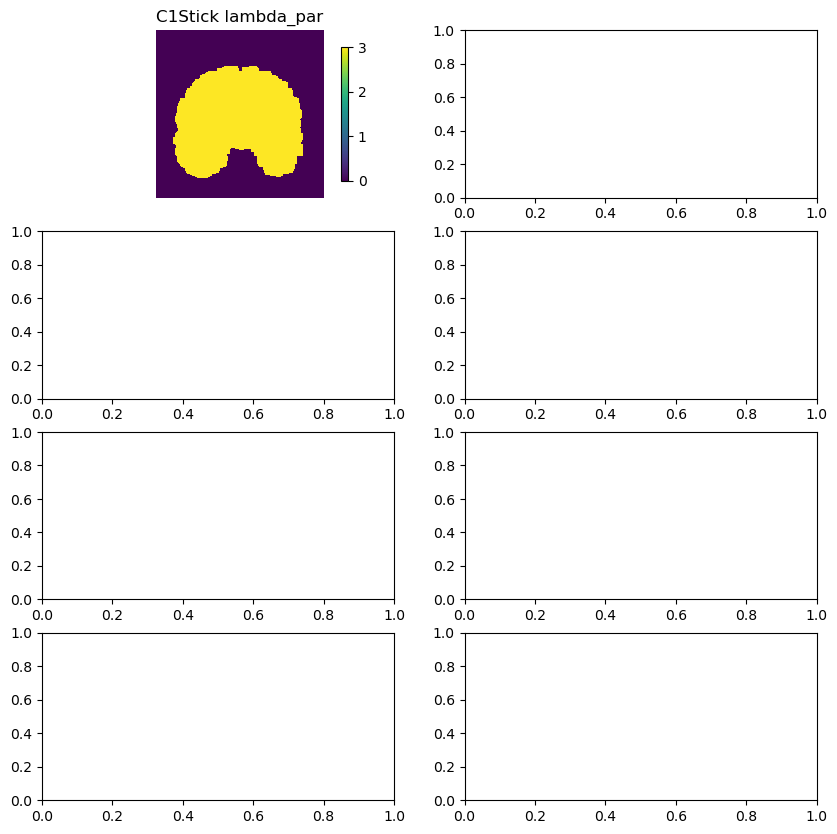

In [51]:
fig, axs = plt.subplots(4, 2, figsize=[10, 10])
axs = axs.ravel()

cf = axs[0].imshow(lambda_par_pred_train_3d[:,100,:].squeeze().T, origin='lower', interpolation='nearest')
axs[0].set_title("C1Stick lambda_par")
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.8)

cf = axs[1].imshow(fitted_parameters.get("C1Stick_1_lambda_par").squeeze().T, origin='lower', interpolation='nearest')
axs[1].set_title("C1Stick lambda_par")
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.8)

cf = axs[2].imshow(lambda_iso_pred_train_3d[:,100,:].squeeze().T, origin='lower', interpolation='nearest')
axs[2].set_title("G1Ball lambda_iso")
axs[2].set_axis_off()
fig.colorbar(cf, ax=axs[2], shrink=0.8)

cf = axs[3].imshow(fitted_parameters.get("G1Ball_1_lambda_iso").squeeze().T, origin='lower', interpolation='nearest')
axs[3].set_title("G1Ball lambda_iso")
axs[3].set_axis_off()
fig.colorbar(cf, ax=axs[3], shrink=0.8)

cf = axs[4].imshow(volume_0_pred_train_3d[:,110,:].squeeze().T, origin='lower', interpolation='nearest')
axs[4].set_title("partial volume of Stick")
axs[4].set_axis_off()
fig.colorbar(cf, ax=axs[4], shrink=0.8)
cf = axs[5].imshow(fitted_parameters.get("partial_volume_0").squeeze().T, origin='lower', interpolation='nearest')
axs[5].set_title("partial volume of Stick")
axs[5].set_axis_off()
fig.colorbar(cf, ax=axs[5], shrink=0.8)

cf = axs[6].imshow(volume_1_pred_train_3d[:,110,:].squeeze().T, origin='lower', interpolation='nearest')
axs[6].set_title("partial volume of Ball")
axs[6].set_axis_off()
fig.colorbar(cf, ax=axs[6], shrink=0.8)
cf = axs[7].imshow(fitted_parameters.get("partial_volume_1").squeeze().T, origin='lower', interpolation='nearest')
axs[7].set_title("partial volume of Ball")
axs[7].set_axis_off()
fig.colorbar(cf, ax=axs[7], shrink=0.8)

In [46]:
scan_100206_slice = scan_100206[:, 100, :, :]

In [47]:
def get_acquisition_scheme(bvals, gradient_directions):
    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [48]:
scheme_hcp_100206_slice = get_acquisition_scheme(bvals_all*1e9, n_all.T)

In [49]:
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
BAS_mod = MultiCompartmentModel(models=[stick, ball])

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


In [50]:
BAS_fit_hcp_100206_slice = BAS_mod.fit(scheme_hcp_100206_slice, scan_100206_slice, mask_100206[:,100,:])

Setup brute2fine optimizer in 0.2092270851135254 seconds
Fitting of 8433 voxels complete in 198.88885593414307 seconds.
Average of 0.023584591003693 seconds per voxel.


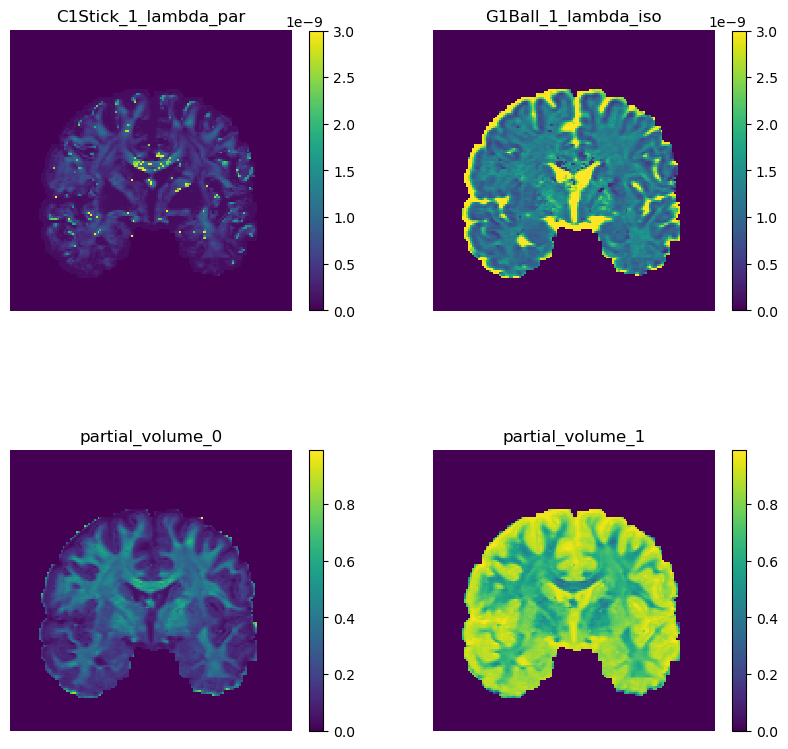

In [105]:
fitted_parameters = BAS_fit_hcp_100206_slice.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin='lower', interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)
    counter += 1

In [111]:
fitted_parameters.keys()

dict_keys(['C1Stick_1_mu', 'C1Stick_1_lambda_par', 'G1Ball_1_lambda_iso', 'partial_volume_0', 'partial_volume_1'])